In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
import seaborn as sns
from lib.data import semi_empirical_mass_formula, BW2_mass_formula
sns.set_style('darkgrid')
sns.set_context('paper')

In [2]:
import glob
locations = glob.glob('/n/holyscratch01/iaifi_lab/kitouni/mech-interp-experiments/experiments/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}

# Explorations

## Embeddings

In [3]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds(X, model, data, batch = 200):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = inverse_transform(model(X[i:i+batch]), data)
            preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def get_rms(X, y, model, data):
    preds = get_preds(X, model, data)
    rms = {}
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

/n/home13/kitouni/projects/NuCLR-MechInterp/lib/utils.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15*figscale, 3 * num_components*figscale))


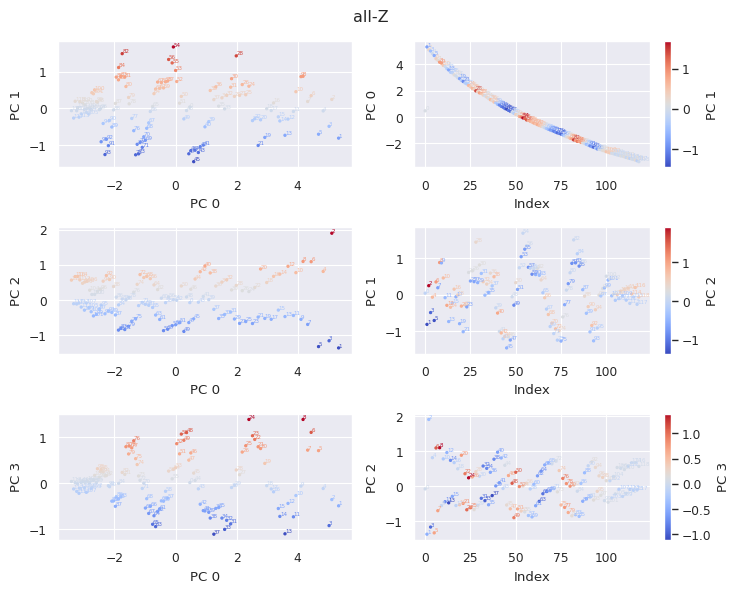

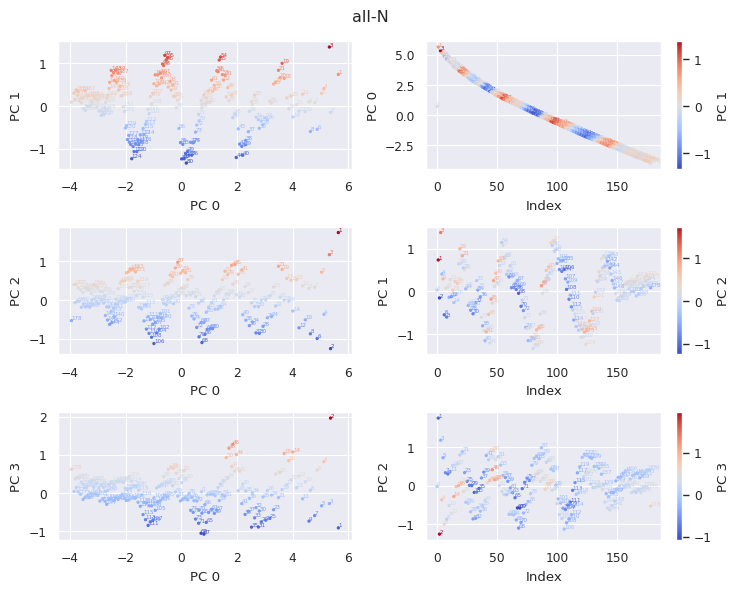

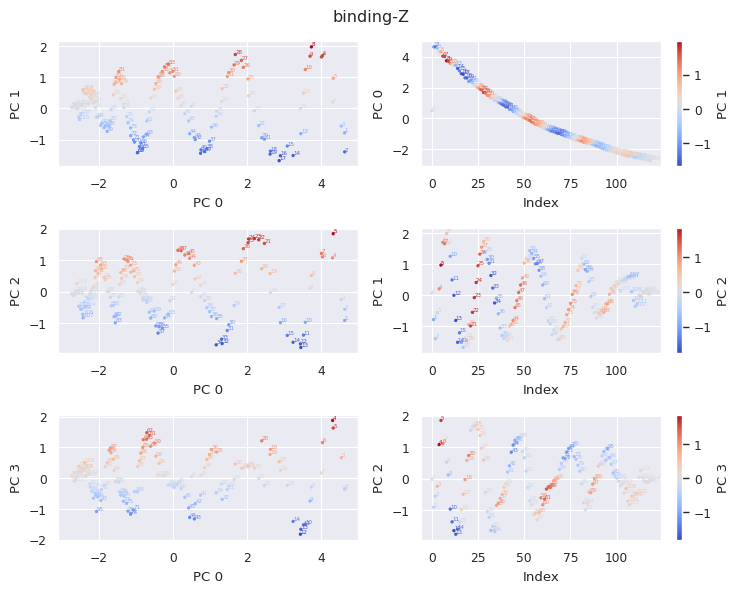

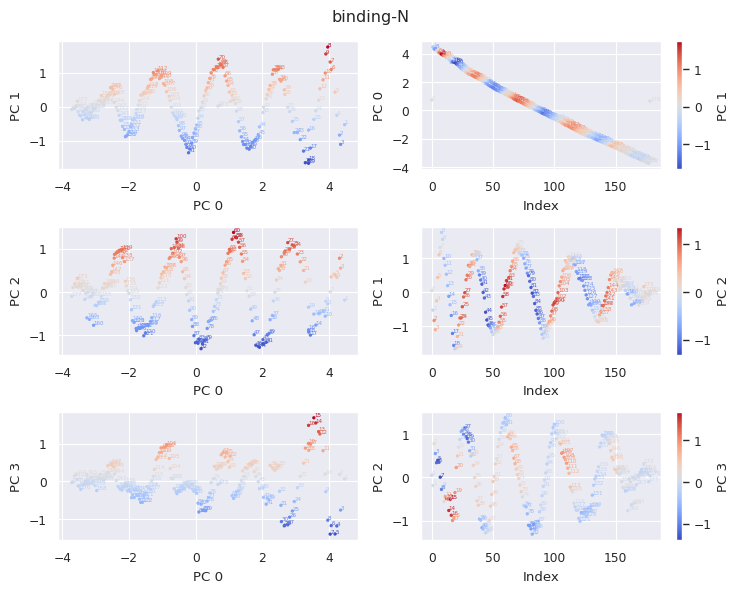

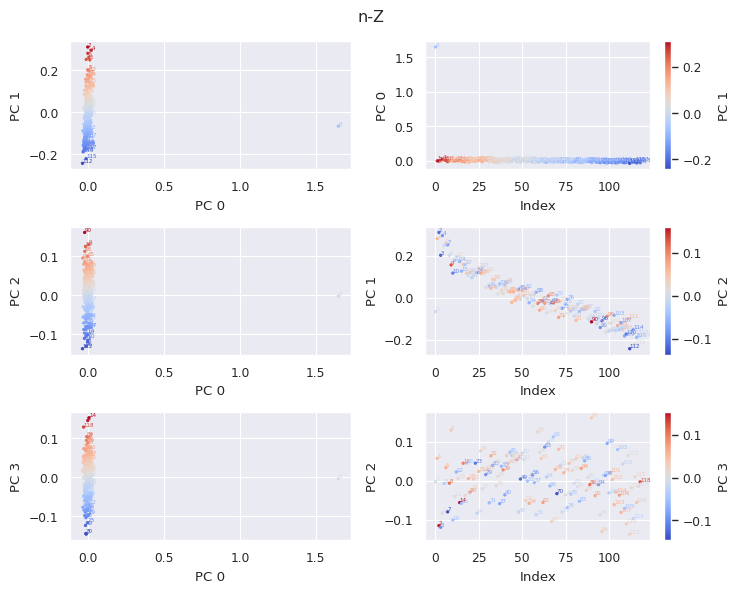

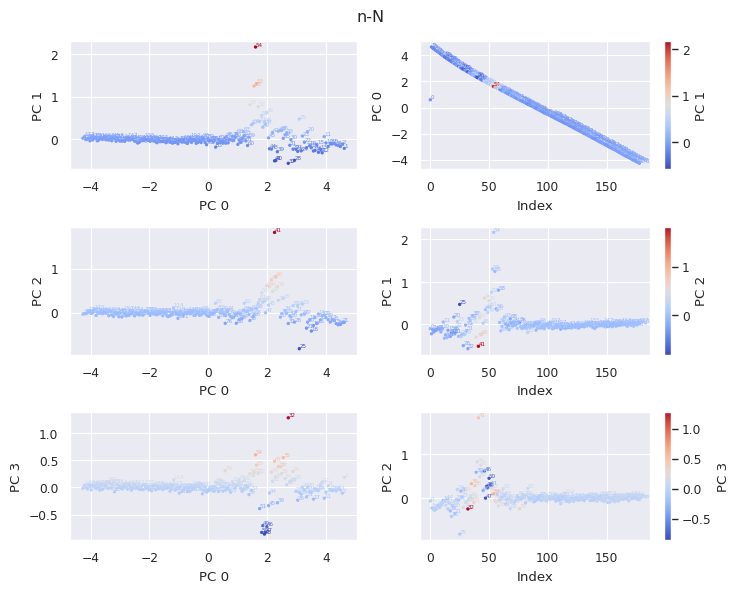

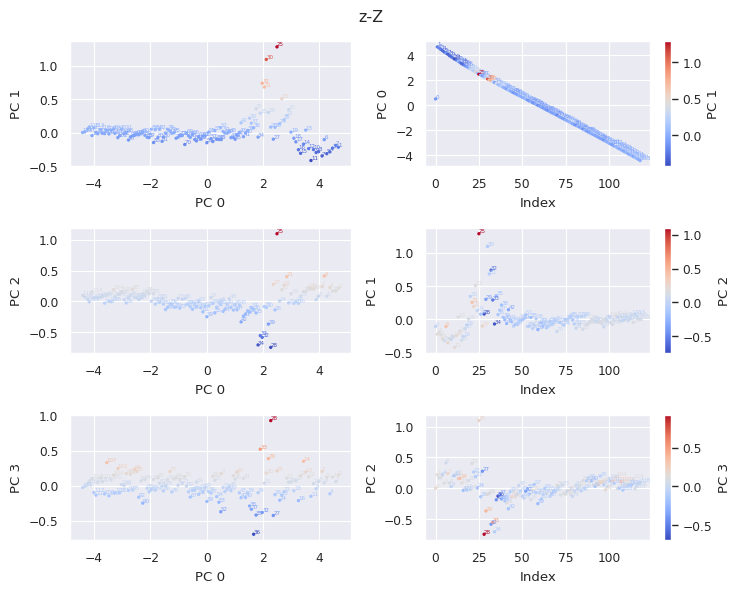

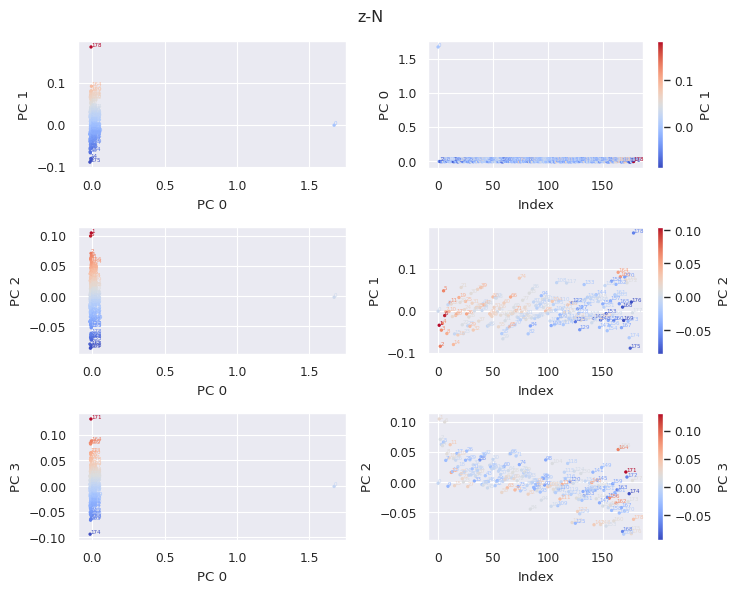

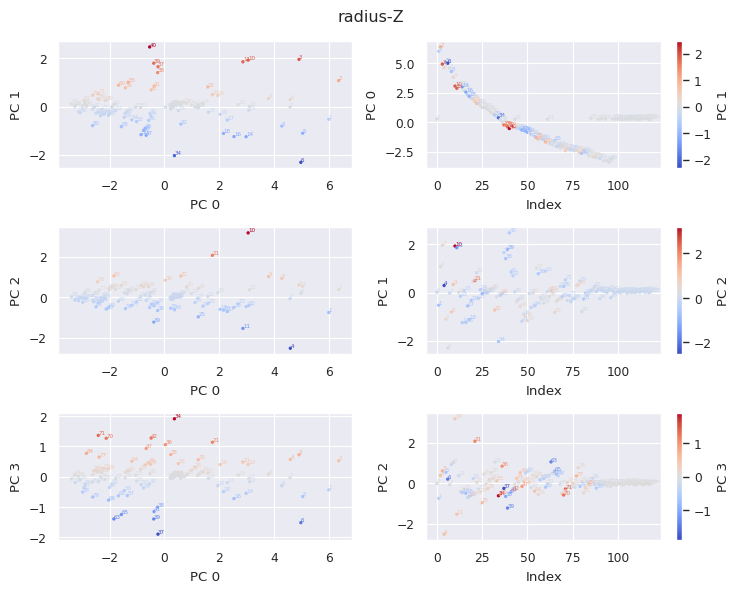

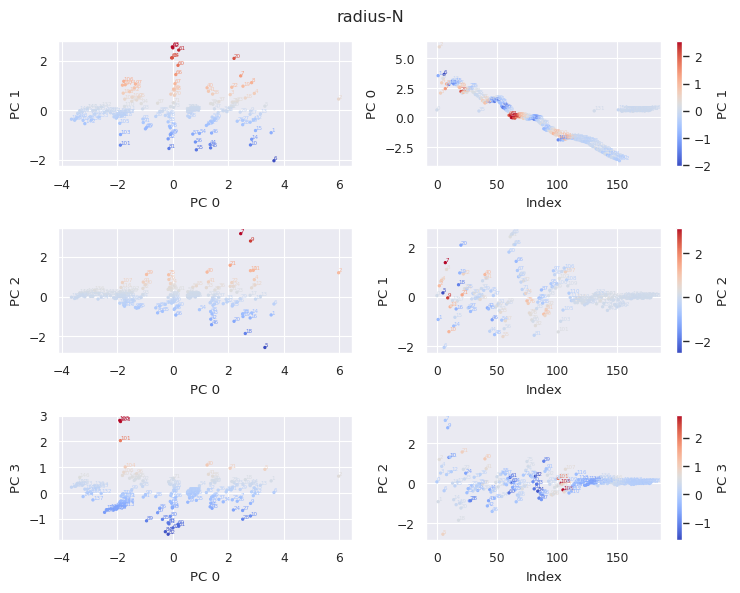

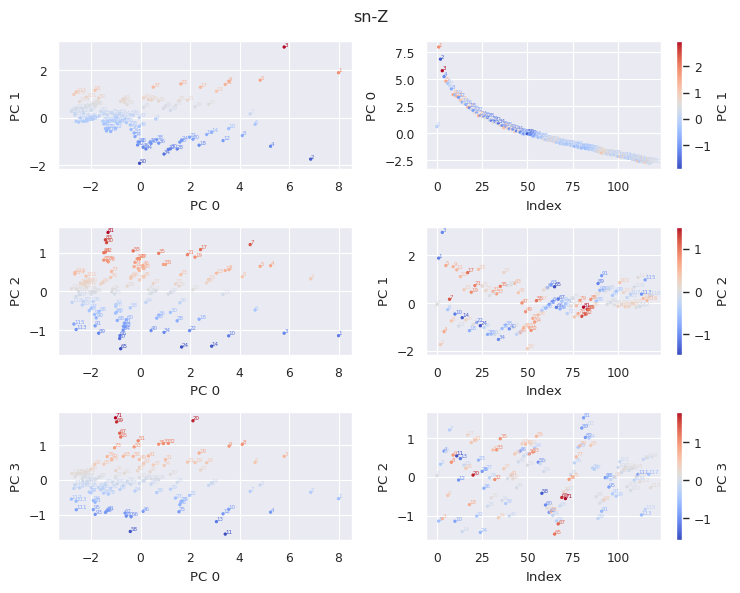

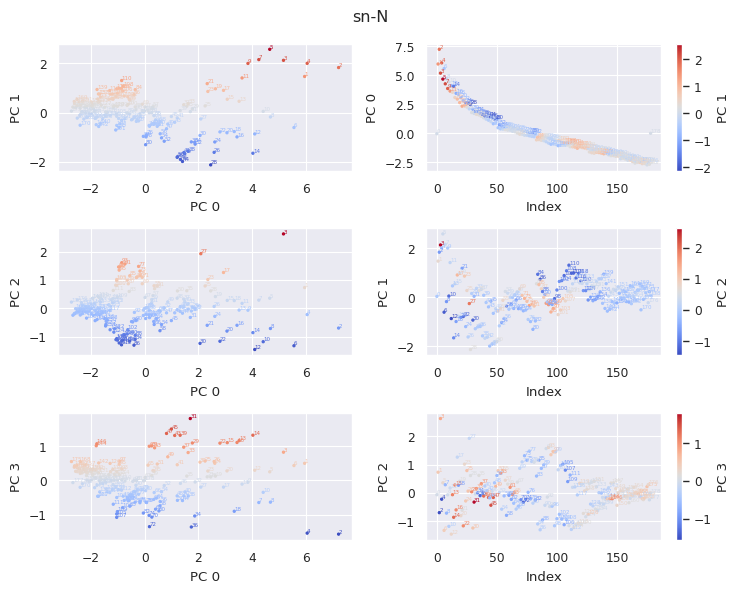

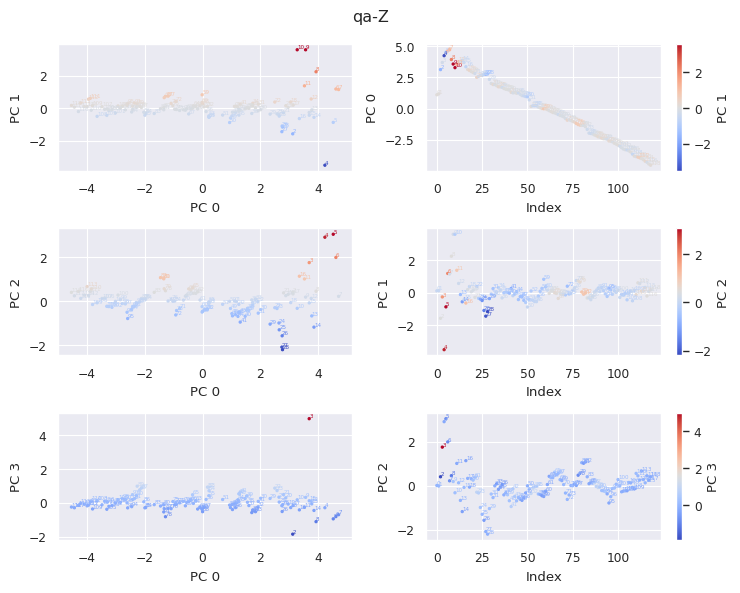

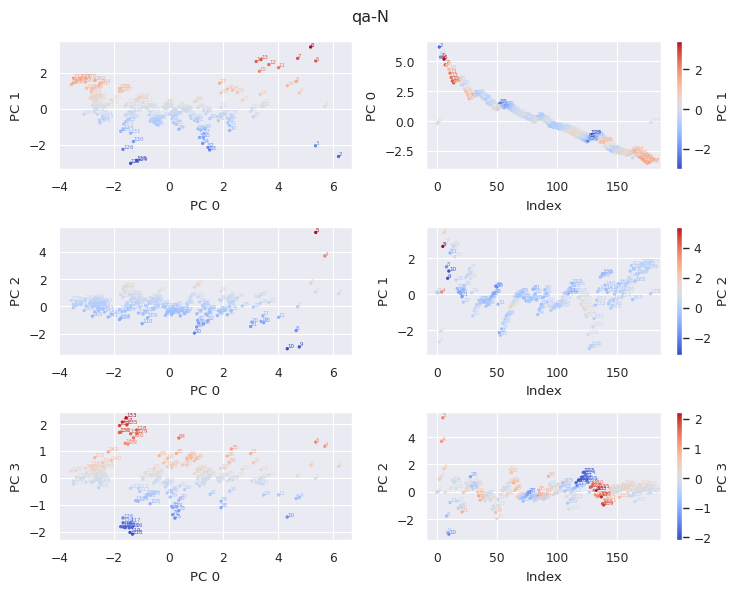

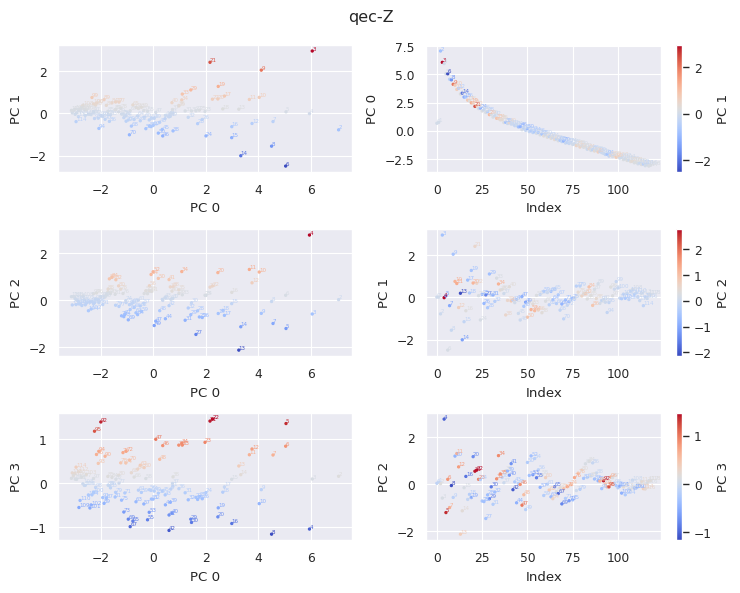

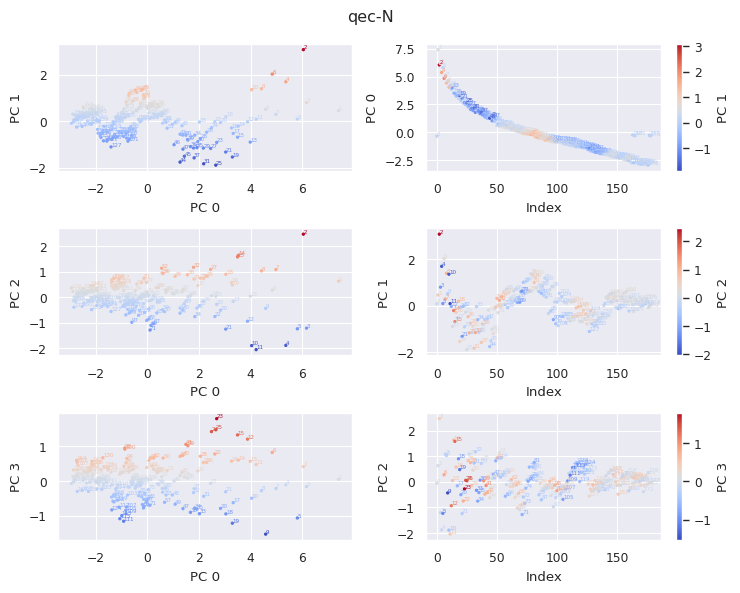

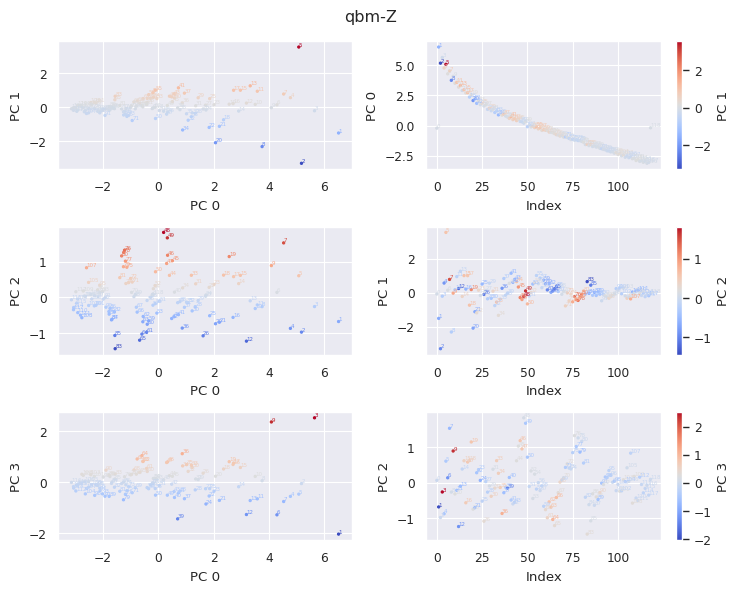

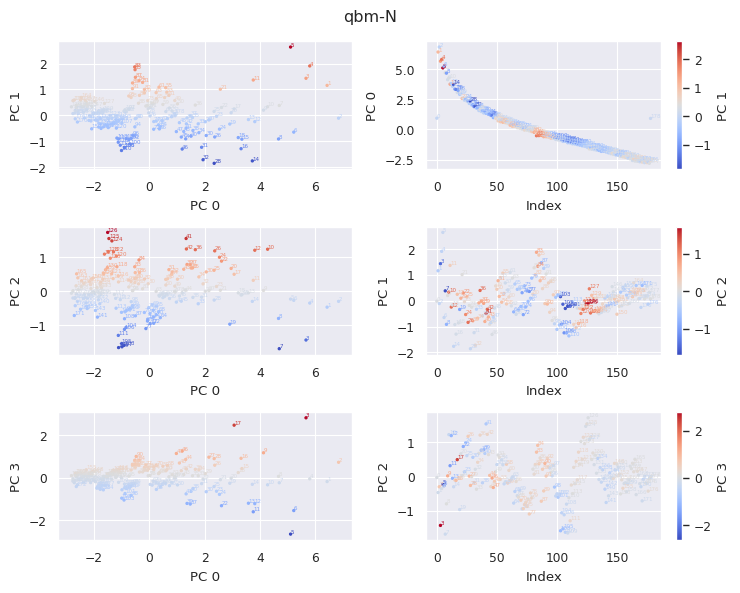

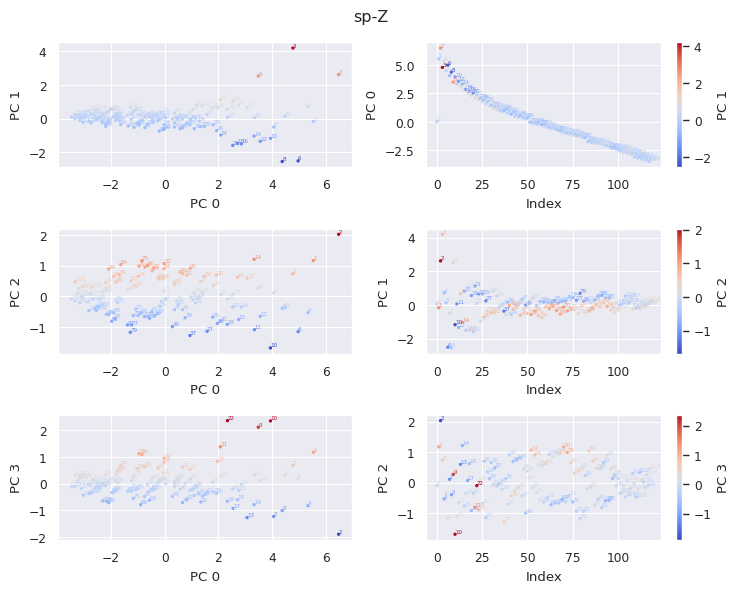

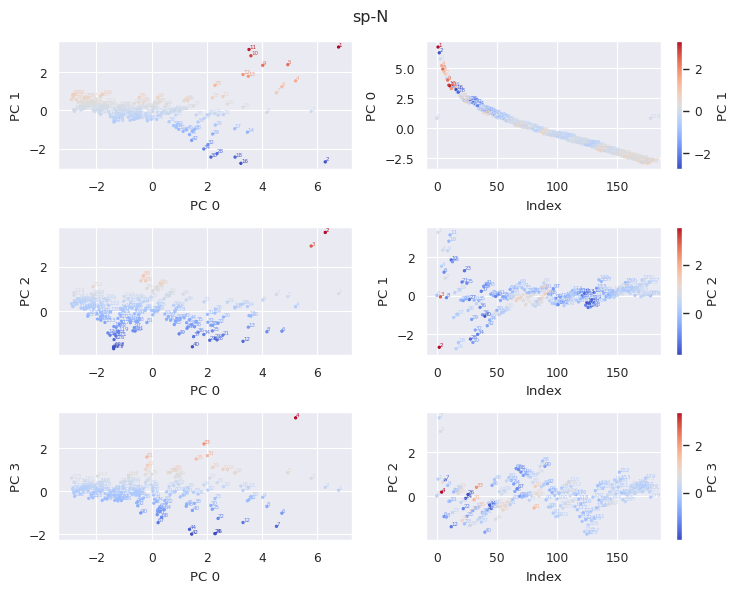

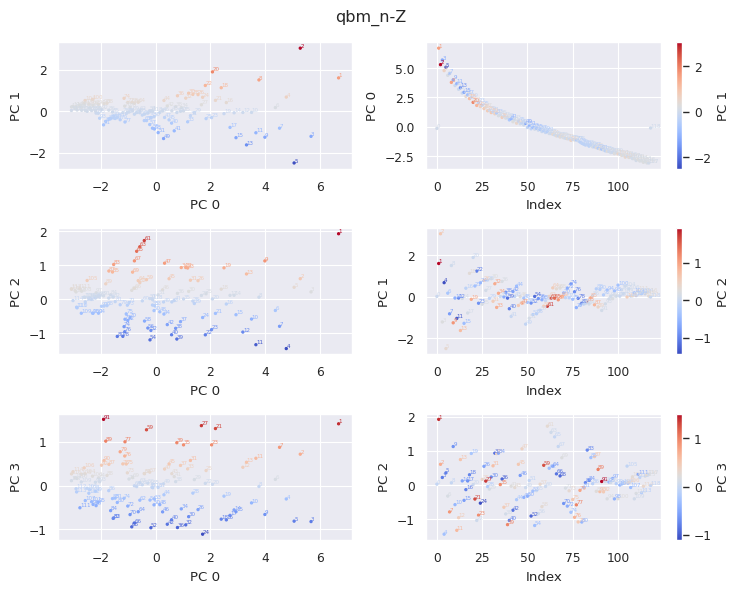

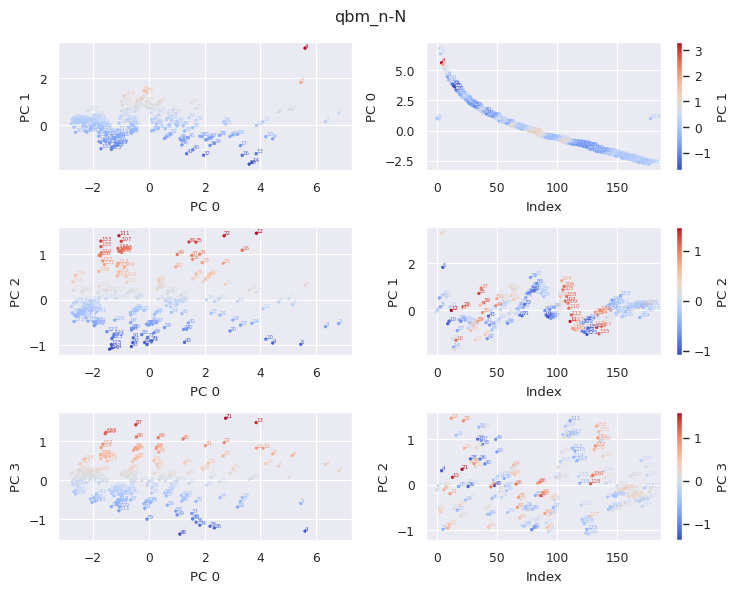

In [12]:
os.makedirs('plots/long-runs', exist_ok=True)
for key, location in locations.items():
    args = IO.load_args(f"{location}/args.yaml")
    args.DEV = "cpu"
    data = prepare_nuclear_data(args)
    model = get_model_and_optim(data, args)[0]
    model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

    # get RMS for each task
    mask = data.val_mask & ~torch.isnan(data.y[:, 0])
    X_val = data.X[mask]
    y_val = data.y[mask]

    mask = data.train_mask & ~torch.isnan(data.y[:, 0])
    X_train = data.X[mask]
    y_train = data.y[mask]
        
    rms_train = get_rms(X_train, y_train, model, data)
    rms_val = get_rms(X_val, y_val, model, data)
    task_rms_values[key] = (rms_train, rms_val)
    
    nucleon = "ZN"
    for i in range(2):
        emb = model.emb[i].detach().numpy()
        fig = PlottingContext.plot_embedding(emb, num_components=4, figscale=0.5)
        fig.suptitle(key+f"-{nucleon[i]}"); fig.tight_layout()
        fig.savefig(f'plots/long-runs/{key}-{nucleon[i]}-emb.pdf', bbox_inches='tight')

## Features

In [4]:
location = locations['all']
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]

<All keys matched successfully>

In [6]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(lambda m, i: acts.copy_(i[0].detach()))
    model(X)
    hook.remove()
    return acts

def output_to_rms(outputs, X, y):
    preds = inverse_transform(outputs, data)
    preds = preds.gather(1, X[:, 2].long().view(-1, 1))
    mask = lambda x: x[X[:, 2] == 0].cpu().detach().squeeze().numpy()
    preds, targets, zn = mask(preds), mask(y), mask(X[:, :2])
    rms = np.sqrt(np.mean((preds - targets)**2))
    return rms

acts = get_penultimate_acts(model, X_train)
rms = output_to_rms(model.readout(acts), X_train, y_train)
print(f"RMS of readout layer: {rms:.2f}")

: 

In [20]:
acts = get_penultimate_acts(model, X_train)
X = X_train
outputs = model.readout(acts)
preds = inverse_transform(outputs, data)
preds = preds.gather(1, X[:, 2].long().view(-1, 1))
mask = lambda x: x[X[:, 2] == 0].cpu().detach().squeeze().numpy()
preds, targets, zn = mask(preds), mask(y_train), mask(X[:, :2])
preds, targets

(array([   7231.13380686,    6928.7899219 ,    6144.26316364, ...,
        2077063.92560562, 2082735.78166446, 2083937.63861514]),
 array([  1618.592,  22396.213,  22573.172, ..., -11592.   , -11125.   ,
        -10477.   ], dtype=float32))

In [ ]:
preds = inverse_transform(outputs, data)
preds = preds.gather(1, X[:, 2].long().view(-1, 1))
preds

tensor([[   7231.1338],
        [   6928.7899],
        [   6144.2632],
        ...,
        [2077063.9256],
        [2082735.7817],
        [2083937.6386]], dtype=torch.float64, grad_fn=<GatherBackward0>)

In [ ]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(acts.cpu().numpy())

# project to first n components
ns = np.arange(1, n_components+1)
rms_by_n = {}
for n in ns:
    acts_pca = pca.transform(acts.cpu().numpy())
    acts_pca[:, n:] = 0
    acts_ = pca.inverse_transform(acts_pca)
    acts_ = torch.tensor(acts_, device=device)
    rms = output_to_rms(new_model.readout(acts_), X_train, y_train)
    rms_by_n[n] = rms

plt.plot(ns, rms_by_n.values())
plt.xlabel("Number of components kept")
plt.ylabel("RMS [keV]")

# Paper plots